## Imports and experiment setup

In [1]:
%run header.py
%matplotlib inline

from utils import combine_with_identity

In [2]:
exp_path = '/nmnt/x04-hdd/boris_temp/SGIMC_IMC/covtype/'

In [3]:
PROBLEM = "classification" if True else "regression"

step_fn = step_qaadmm

if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
else:
    QAObjectiveLoss = QAObjectiveL2Loss  # QAObjectiveHuberLoss

In [4]:
C_ridge = 1e-4
Cs_group = [2e-1, 2e-4]
eta = 1e0

## Parameter to vary

In [5]:
elements = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.008, 0.01]

## Data loading

In [6]:
R_full = np.load(exp_path + 'R.npy')
X = np.load(exp_path + 'X.npy')

Y = np.eye(len(R_full))
y_mask = np.array(Y, dtype='bool')
Y = sparsify_with_mask(Y, y_mask)

## Run experiment (K = 5 )

In [7]:
K = 5 # K = X.shape[1]
n_iter = 100

In [9]:
accs = []
for n in tqdm(elements):
    R_train, mask = sparsify(R_full, n, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    C_accuracies = []
    for C_group in Cs_group:
        C_lasso = 10 * C_group
        C = (C_lasso, C_group, C_ridge)
        step_kwargs = {
            "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
            "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
            "rtol": 1e-2,           # the relative tolerance for stopping the ADMM
            "atol": 1e-4,           # the absolute tolerance
            "method": "tron",       # the method to use in Sub_0
            "n_iterations": 2,      # the number of iterations of the inner ADMM
        }
        
        W_0 = random_state.normal(size=(X.shape[1], K))
        H_0 = random_state.normal(size=(Y.shape[1], K))

        W, H = W_0.copy(), H_0.copy()
        
        W, H = imc_descent(problem, W, H,
                           step_fn,                  # the inner optimization
                           step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                           n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                           n_init_iterations=0,
                           return_history=True,      # Record the evolution of the matrices (W, H)
                           rtol=1e-3,                # relative stopping tolerance for the outer iterations
                           atol=1e-5,                # absolute tolerance
                           verbose=False,            # show the progress bar
                           check_product=True,       # use the product W H' for stopping
                           )
        
        R_hat = get_prediction(X, W, H, Y, binarize=True)
        C_accuracies.append(accuracy(R_full, R_hat, invert(mask)))
        
    accs.append(np.max(C_accuracies))

accs = np.array(accs)
np.save(exp_path + 'results_sgimc_accuracies.npy', accs)

100%|██████████| 8/8 [55:44<00:00, 593.24s/it]


## Combining features + identity matrix

In [8]:
X_comb = combine_with_identity(X)

In [ ]:
accs = []
for n in tqdm(elem_upd):
    
    R_train, mask = sparsify(R_full, n, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X_comb, Y, R_train, n_threads=8)
    
    C_accuracies = []
    for C_group in Cs_group:
        C_lasso = 10 * C_group
        C = (C_lasso, C_group, C_ridge)
        step_kwargs = {
            "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
            "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
            "rtol": 1e-2,           # the relative tolerance for stopping the ADMM
            "atol": 1e-4,           # the absolute tolerance
            "method": "tron",       # the method to use in Sub_0
            "n_iterations": 2,      # the number of iterations of the inner ADMM
        }

        W_0 = random_state.normal(size=(X_comb.shape[1], K))
        H_0 = random_state.normal(size=(Y.shape[1], K))

        W, H = W_0.copy(), H_0.copy()

        W, H = imc_descent(problem, W, H,
                           step_fn,                  # the inner optimization
                           step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                           n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                           n_init_iterations=0,
                           return_history=True,      # Record the evolution of the matrices (W, H)
                           rtol=1e-3,                # relative stopping tolerance for the outer iterations
                           atol=1e-5,                # absolute tolerance
                           verbose=False,            # show the progress bar
                           check_product=True,       # use the product W H' for stopping
                           )

        R_hat = get_prediction(X_comb, W, H, Y, binarize=True)
        C_accuracies.append(accuracy(R_full, R_hat, invert(mask)))

    accs.append(np.max(C_accuracies))

accs = np.array(accs)
np.save(exp_path + 'results_sgimc_accuracies_comb.npy', accs)

 22%|██▏       | 2/9 [01:31<05:05, 43.69s/it]

## Plots

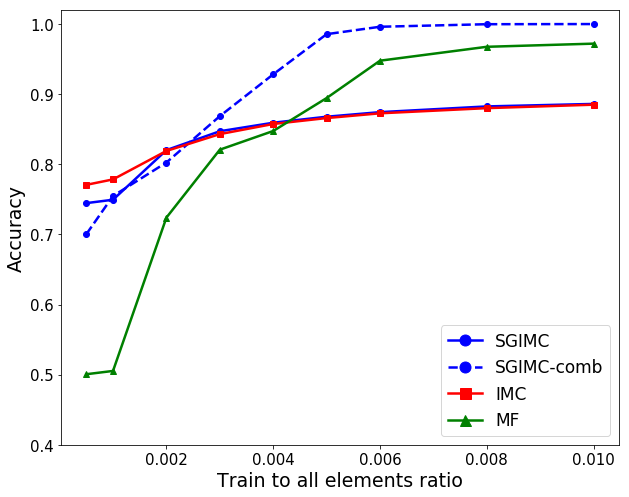

In [8]:
exp_path = '/nmnt/x04-hdd/boris_temp/SGIMC_IMC/covtype/'

# loading results
accuracies_sgimc = np.load(exp_path + 'results_sgimc_accuracies.npy')
accuracies_sgimc_comb = np.load(exp_path + 'results_sgimc_accuracies_comb.npy')
accuracies_imc = np.load(exp_path + 'results_imc_accuracies.npy')
accuracies_mf = np.load(exp_path + 'results_mf_accuracies.npy')


################################### FIGURE ###################################
plt.figure(figsize=(10,8))

# lines
sgimc_line = mlines.Line2D([], [], color='blue', marker='o', linewidth=2.5,
                           markersize=11, label='SGIMC')
sgimc_comb_line = mlines.Line2D([], [], color='blue', marker='o', linewidth=2.5, linestyle='--',
                                markersize=11, label='SGIMC-comb')
imc_line = mlines.Line2D([], [], color='red', marker='s', linewidth=2.5,
                         markersize=11, label='IMC')
mf_line = mlines.Line2D([], [], color='green', marker='^', linewidth=2.5,
                        markersize=11, label='MF')


# curves
plt.plot(elements, accuracies_sgimc, 'b-', label='SGIMC', linewidth=2.5)
plt.plot(elements, accuracies_sgimc_comb, 'b--', label='SGIMC-comb', linewidth=2.5)
plt.plot(elements, accuracies_imc, 'r-', label='IMC', linewidth=2.5)
plt.plot(elements, accuracies_mf, 'g-', label='MF', linewidth=2.5)

# dotes
plt.plot(elements, accuracies_sgimc, 'bo', label='SGIMC', linewidth=2.5)
plt.plot(elements, accuracies_sgimc_comb, 'bo', label='SGIMC-comb', linewidth=2.5)
plt.plot(elements, accuracies_imc, 'rs', label='IMC', linewidth=2.5)
plt.plot(elements, accuracies_mf, 'g^', label='MF', linewidth=2.5)

# specify axis limits and labels
plt.ylim((0.4,1.02))
plt.xlabel('Train to all elements ratio', fontsize=19)
plt.ylabel('Accuracy', fontsize=19)

# ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# legend
plt.legend(handles=[sgimc_line, sgimc_comb_line, imc_line, mf_line], fontsize=17, loc=4)

plt.show()
# TODO: save as pdf
# TODO: dpi 200